In [1]:
import os
import sys
from pathlib import Path
import importlib

def find_project_root():
    path = Path(os.getcwd()).resolve()
    for parent in [path] + list(path.parents):
        if (parent / "src").exists():
            return parent
    return path

root_dir = find_project_root()
os.chdir(root_dir)

if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))

from src.utils_audio import *

In [2]:
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

from src import config as cfg
from src.train_module import AudioCodecModule
from src.utils_audio import mel_spectrogram, griffin_lim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

ckpt_path = "lightning_logs/checkpoints/last.ckpt"

model = AudioCodecModule.load_from_checkpoint(
    ckpt_path,
    map_location=device
).to(device).eval()

print("Model loaded.")

Using device: cuda
Model loaded.


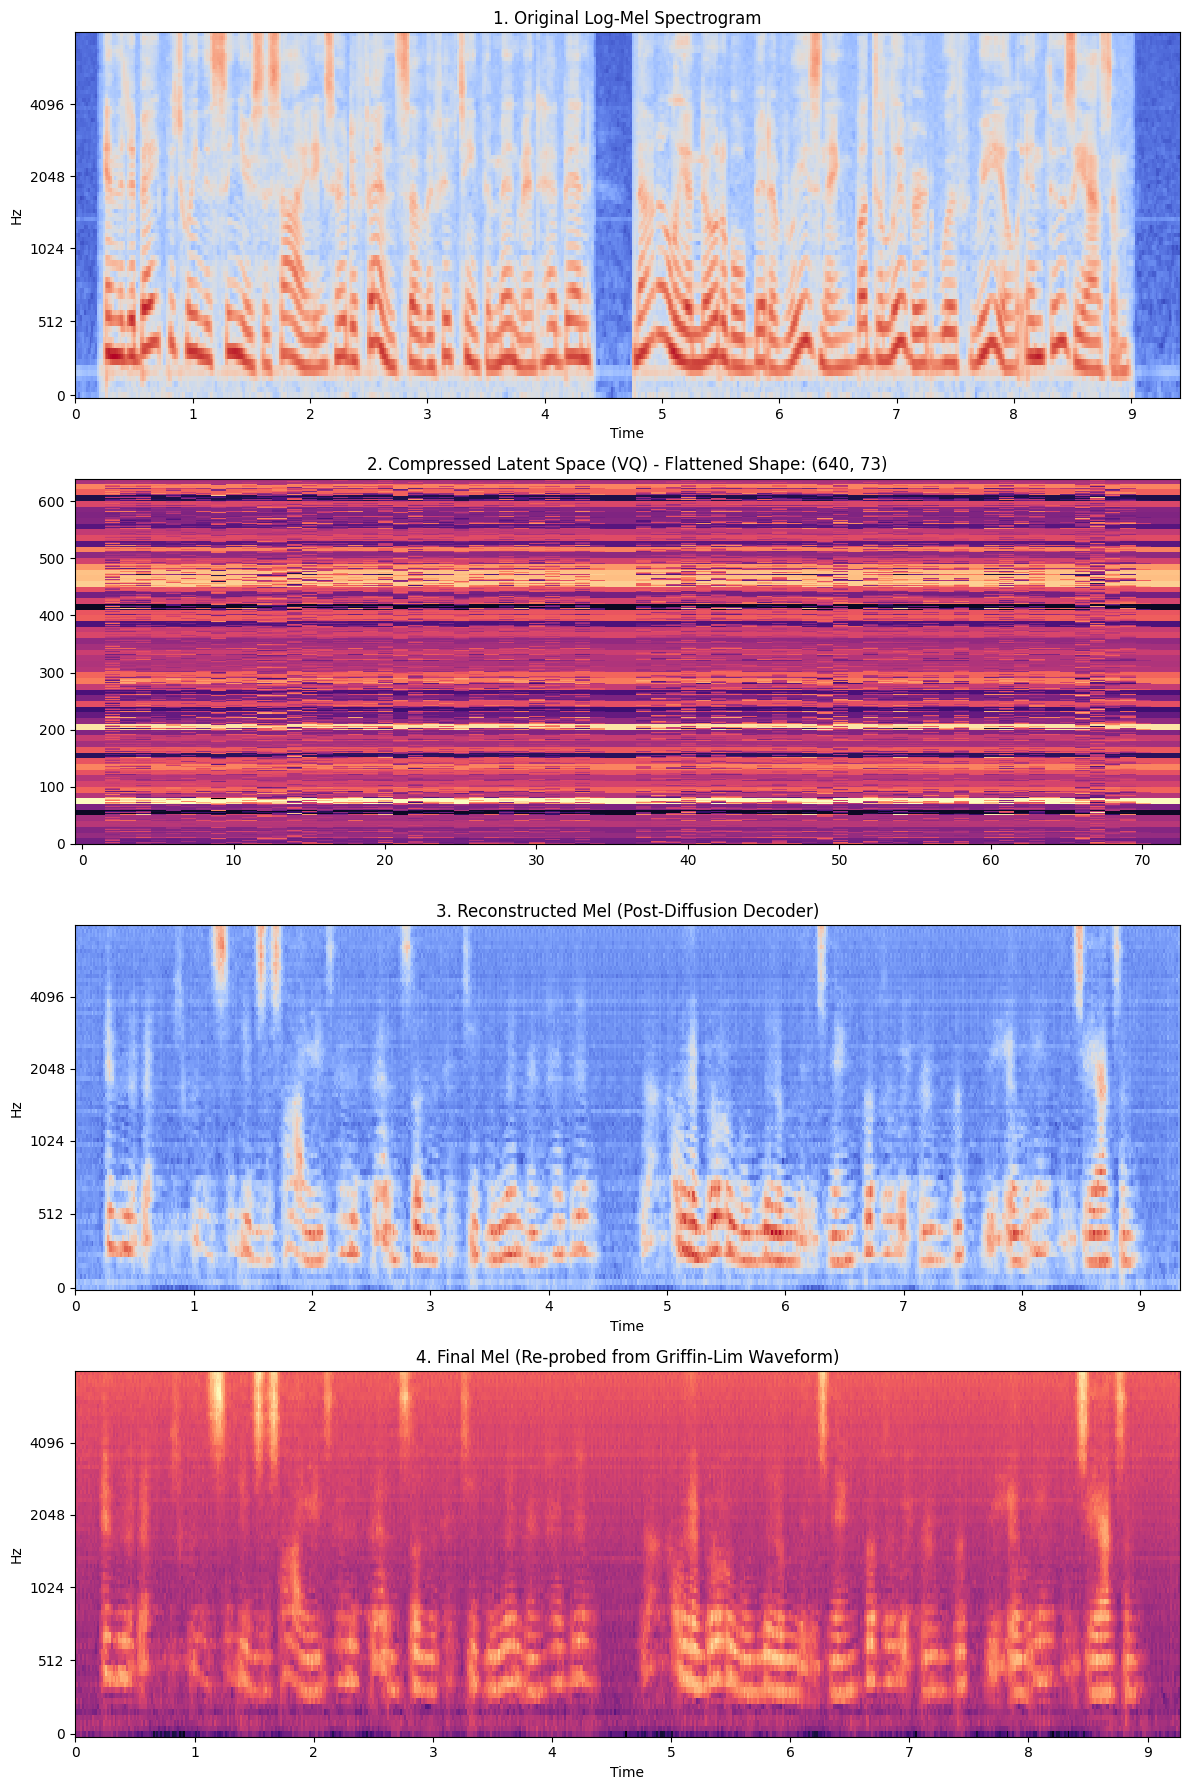

Original Audio:


Diffusion + Griffin-Lim Audio:


In [ ]:
test_files = sorted(list(Path("data/raw/test-clean").rglob("*.flac")))
if not test_files:
    raise FileNotFoundError("Check data/raw/test-clean path.")

audio_path = test_files[0]
wav, _ = librosa.load(audio_path, sr=cfg.SAMPLE_RATE)
wav_tensor = torch.from_numpy(wav).unsqueeze(0).to(device)

orig_mel = mel_spectrogram(
    wav_tensor, 
    n_fft=cfg.N_FFT, 
    num_mels=cfg.N_MELS, 
    sampling_rate=cfg.SAMPLE_RATE, 
    hop_size=cfg.HOP_LENGTH, 
    win_size=cfg.N_FFT, 
    fmin=cfg.F_MIN, 
    fmax=cfg.F_MAX
)

with torch.no_grad():
    z_q, _, _ = model.model.encoder(orig_mel)
    
    t = torch.zeros(1, device=device).long()
    recon_mel = model.model.decoder(z_q, t)

recon_wav = griffin_lim(recon_mel)

recon_wav_tensor = torch.from_numpy(recon_wav).unsqueeze(0).to(device) 
final_mel = mel_spectrogram(
    recon_wav_tensor,
    n_fft=cfg.N_FFT,
    num_mels=cfg.N_MELS,
    sampling_rate=cfg.SAMPLE_RATE,
    hop_size=cfg.HOP_LENGTH,
    win_size=cfg.N_FFT,
    fmin=cfg.F_MIN,
    fmax=cfg.F_MAX
)

fig, axes = plt.subplots(4, 1, figsize=(12, 18))

librosa.display.specshow(orig_mel[0, 0].cpu().numpy(), x_axis='time', y_axis='mel', 
                         sr=cfg.SAMPLE_RATE, hop_length=cfg.HOP_LENGTH, ax=axes[0])
axes[0].set_title("1. Original Log-Mel Spectrogram")

latent_viz = z_q[0].cpu().numpy().reshape(-1, z_q.shape[-1])
axes[1].imshow(latent_viz, aspect='auto', origin='lower', interpolation='none', cmap='magma')
axes[1].set_title(f"2. Compressed Latent Space (VQ) - Flattened Shape: {latent_viz.shape}")

librosa.display.specshow(recon_mel[0, 0].cpu().numpy(), x_axis='time', y_axis='mel', 
                         sr=cfg.SAMPLE_RATE, hop_length=cfg.HOP_LENGTH, ax=axes[2])
axes[2].set_title("3. Reconstructed Mel (Post-Diffusion Decoder)")

librosa.display.specshow(final_mel[0, 0].cpu().numpy(), x_axis='time', y_axis='mel', 
                         sr=cfg.SAMPLE_RATE, hop_length=cfg.HOP_LENGTH, ax=axes[3])
axes[3].set_title("4. Final Mel (Re-probed from Griffin-Lim Waveform)")

plt.tight_layout()
plt.show()

print("Original Audio:")
ipd.display(ipd.Audio(wav, rate=cfg.SAMPLE_RATE))

print("Diffusion + Griffin-Lim Audio:")
ipd.display(ipd.Audio(recon_wav, rate=cfg.SAMPLE_RATE))